In [39]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from keras import layers
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [10]:
train = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)

In [11]:
train_ds = train.flow_from_directory('/mnt/c/users/efazh/DataProblems/Datasets/ComputerVision/Covid19-dataset/train',
                                     target_size = (224,224), batch_size = 10)

test_ds = test.flow_from_directory('/mnt/c/users/efazh/DataProblems/Datasets/ComputerVision/Covid19-dataset/test',
                                  target_size = (224,224), batch_size = 10)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


# Data Augmentation

In [23]:
# Define augmentation parameters
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

# Load images with augmentation from directory
train_generator = train_datagen.flow_from_directory('/mnt/c/users/efazh/DataProblems/Datasets/ComputerVision/Covid19-dataset/train',
                                                    target_size = (224,224), batch_size = 10)
, class_mode='binary'

Found 251 images belonging to 3 classes.


"class_mode='binary'"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

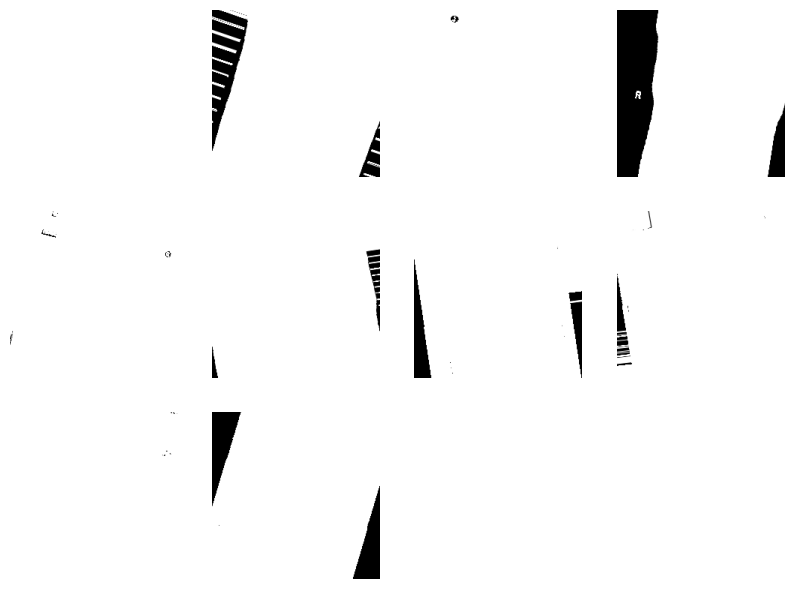

In [31]:
# Generate a batch of augmented images
augmented_images, _ = train_generator.next()

# Display the augmented images
plt.figure(figsize=(10, 10))
for i in range(len(augmented_images)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()

# Train Augmented Images

In [35]:
from tensorflow.keras.models import load_model

model_path = '/mnt/c/users/efazh/DataProblems/DATA-4380/Projects/ComputerVision/my_vgg16_model.h5'

# Load the model
loaded_model = load_model(model_path)

In [47]:
# Use the loaded model for prediction
predictions = loaded_model.predict(augmented_images)

# Display the predictions
score = tf.nn.softmax(predictions[0])

1/1 [==============================] - 0s 177ms/step
